# Solving Poisson's equation on topological domains

## Step 1 : Building the domain
Psydac uses the powerful topological tools of SymPDE to build a large variety of domains.  
Here we are going to use a square and a PolarMapping to build a quarter annulus.

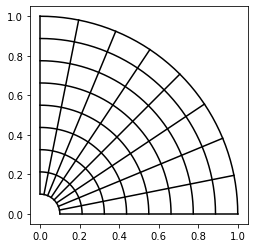

In [2]:

import numpy as np

from sympde.topology import Square, PolarMapping

from psydac.utilities.plot_domain import plot_topological_domain

# Define the topological geometry
domain_log = Square('A', bounds1=(0., 1.), bounds2=(0., np.pi/2))
F = PolarMapping('F', dim=2, c1= 0., c2= 0., rmin = 0.1, rmax=1.)
Omega = F(domain_log)

# Simple visualization of the topological domain
plot_topological_domain(Omega)

In [3]:
from sympde.calculus import grad, dot, rot
from sympde.calculus import laplace, bracket, convect
from sympde.calculus import minus, plus

from sympde.expr.expr          import LinearExpr
from sympde.expr.expr          import LinearForm, BilinearForm
from sympde.expr.expr          import integral              
from sympde.expr.expr          import Norm                       
from sympde.expr               import find, EssentialBC

from sympde.topology import ScalarFunctionSpace
from sympde.topology import elements_of
from sympde.topology import NormalVector

# Define the abstract model to solve Poisson's equation using the manufactured solution method
x,y       = Omega.coordinates
solution  = x**2 + y**2
f         = -4

V   = ScalarFunctionSpace('V', Omega, kind=None)

u, v = elements_of(V, names='u, v')
nn   = NormalVector('nn')

bc   = EssentialBC(u, solution, Omega.boundary)

error  = u - solution

I = Omega.interfaces

kappa  = 10**3

expr_I =- 0.5*dot(grad(plus(u)),nn)*minus(v)  + 0.5*dot(grad(minus(v)),nn)*plus(u)  - kappa*plus(u)*minus(v)\
        + 0.5*dot(grad(minus(u)),nn)*plus(v)  - 0.5*dot(grad(plus(v)),nn)*minus(u)  - kappa*plus(v)*minus(u)\
        - 0.5*dot(grad(minus(v)),nn)*minus(u) - 0.5*dot(grad(minus(u)),nn)*minus(v) + kappa*minus(u)*minus(v)\
        + 0.5*dot(grad(plus(v)),nn)*plus(u)   + 0.5*dot(grad(plus(u)),nn)*plus(v)   + kappa*plus(u)*plus(v)

expr   = dot(grad(u),grad(v))

a = BilinearForm((u,v),  integral(Omega, expr) + integral(I, expr_I))
l = LinearForm(v, integral(Omega, f*v))

equation = find(u, forall=v, lhs=a(u,v), rhs=l(v), bc=bc)

l2norm = Norm(error, Omega, kind='l2')
h1norm = Norm(error, Omega, kind='h1')

In [4]:
# Discretize the geometry
from psydac.api.discretization import discretize

ncells = [5, 5]
degree = [2, 2]

Omega_h = discretize(Omega, ncells=ncells)
Vh      = discretize(V, Omega_h, degree=degree, periodic=[False, False])

equation_h = discretize(equation, Omega_h, [Vh, Vh])

l2norm_h = discretize(l2norm, Omega_h, Vh)
h1norm_h = discretize(h1norm, Omega_h, Vh)

In [5]:
# Set the solver parameters
# 'cg' -> Conjugate gradient method
equation_h.set_solver('cg', info=True, tol=1e-14)

t0_s     = time.time()
uh, info = equation_h.solve()
t1_s     = time.time()


t0_d     = time.time()
l2_error = l2norm_h.assemble(u=uh)
h1_error = h1norm_h.assemble(u=uh)
t1_d     = time.time()

print( '> CG info       :: ',info )
print( '> L2 error      :: {:.2e}'.format(l2_error))
print( '> H1 error      :: {:.2e}'.format(h1_error))
print( '' )
print( '> Solution time :: {:.2e}'.format(t1_s - t0_s))
print( '> Evaluat. time :: {:.2e}'.format(t1_d - t0_d))

> CG info       ::  {'niter': 255, 'success': True, 'res_norm': 5.240832500152967e-15}
> L2 error      :: 4.80e-03
> H1 error      :: 6.53e-02

> Solution time :: 1.10e+01
> Evaluat. time :: 1.26e-01


In [6]:
# Save the results using OutputManager
from psydac.api.postprocessing import OutputManager
import os

os.makedirs('results_poisson', exist_ok=True)

OM = OutputManager(
    f'results_poisson/space_info_{Omega.name}',
    f'results_poisson/field_info_{Omega.name}')

OM.add_spaces(V=Vh)
OM.set_static()
OM.export_fields(u=uh)
OM.export_space_info()
OM.close()

In [7]:
# Export the results to VTK using PostProcessManager
from psydac.api.postprocessing import PostProcessManager
from sympy import lambdify

Pm = PostProcessManager(
    domain=Omega,
    space_file=f'results_poisson/space_info_{Omega.name}.yml',
    fields_file=f'results_poisson/field_info_{Omega.name}.h5')

Pm.export_to_vtk(
    f'results_poisson/visu_{Omega.name}',
    grid=None,
    npts_per_cell=5,
    fields='u',
    additional_physical_functions={'exact_solution': lambdify(Omega.coordinates, solution, modules='numpy')}
)
Pm.close()

<p float="left">
  <img align="top" src="./paraview_images/poisson_pretzel_u.png" width="32%" />
  <img align="top"src="./paraview_images/poisson_pretzel_exact.png" width="32%" />
  <img align="top"src="./paraview_images/poisson_pretzel_error.png" width="32%" />
</p>

